# Import libaries

In [6]:
from pandas_datareader import data as web
import pandas as pd 
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC, SVC


# Get data

In [2]:
data= pd.DataFrame(web.get_data_yahoo('BTC-USD',start="2017-04-15",end="2021-4-22"))
crypto_data=pd.DataFrame()
crypto_data["Close"]=data.Close[:]
crypto_data["Volume"]=data.Volume[:]

# Define function

In [3]:
def model_variables(prices,lags):
  
    
    prices = prices.apply(pd.to_numeric)
    
    inputs = pd.DataFrame(index=prices.index)
    
    inputs["Close"] = prices["Close"]
    inputs["Volume"] = prices["Volume"]
    
    for i in range(0, lags):
        tsret = pd.DataFrame(index=inputs.index)
        inputs["Lag%s" % str(i+1)] = prices["Close"].shift(i+1)
   
   
    tsret["VolumeChange"] =inputs["Volume"].pct_change()
    tsret["returns"] = inputs["Close"].pct_change()*100.0
        
    
    for i,x in enumerate(tsret["returns"]):
        if (abs(x) < 0.0001):
            tsret["returns"][i] = 0.0001
    
   
    for i in range(0, lags):
        tsret["Lag%s" % str(i+1)] = \
          inputs["Lag%s" % str(i+1)].pct_change()*100.0
    

    tsret = tsret.dropna()
    tsret["Direction"] = np.sign(tsret["returns"])
    
  
    tsret.index = pd.to_datetime(tsret.index)
    return tsret

# Test&Train Data

In [4]:

variables_data = model_variables(crypto_data,2)
 

dataset = variables_data[["Lag1","Lag2","VolumeChange","Direction"]]
dataset = dataset.dropna()
 

X = dataset[["Lag1","Lag2","VolumeChange"]]
y = dataset["Direction"]


 
date_split = datetime.datetime(2020,1,1)
 
X_train = X[X.index <= date_split]
X_test =  X[X.index > date_split]
y_train = y[y.index <= date_split]
y_test = y[y.index > date_split]
 
# Create the (parametrised) models
print("Hit Rates/Confusion Matrices:\n")
models = [
              
              
              ("SVM", SVC(
                      C=1000000.0, gamma=0.0001, kernel='rbf',
                    )
  
    
  )]
for m in models:
 
    m[1].fit(X_train, y_train)

    ypt =pd.DataFrame( m[1].predict(X_test))
 
 
    print(m[0], m[1].score(X_test, y_test))
    print( confusion_matrix(ypt, y_test))
    

Hit Rates/Confusion Matrices:

SVM 0.5569620253164557
[[ 33  31]
 [179 231]]


# Trading with Svm prediction

SVM model =  324.6962651559891
Return of SVM model =  549.3925303119782


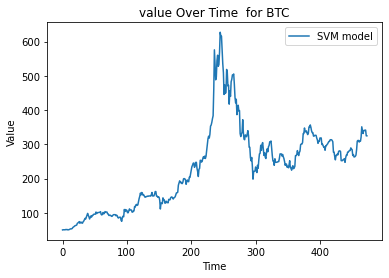

In [5]:
sm=50


modelval = []
f = -1

#base model
for i in range(0,len(ypt)):    
            
        if (ypt[0][i] == 1 and f == -1):
            ns = (sm)/crypto_data.Close[i]
            modelval.append(ns*crypto_data.Close[i])                        
        if (ypt[0][i] == 1 and f == 1):
            modelval.append(ns*crypto_data.Close[i])                        
        if (ypt[0][i] == 1 and f == -1):
            f = 1                        
        if (ypt[0][i] == -1 and f == -1):
            modelval.append(sm)
            sm=sm           
        if (ypt[0][i] == -1 and f == 1): 
            sm = ns*crypto_data.Close[i]
            f = -1
            modelval.append(sm)

returnmodel = (((modelval[472])-50)/50)*100
print('SVM model = ',modelval[472])
print('Return of SVM model = ',returnmodel)




plt.figure()
plt.title('value Over Time  for BTC')
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(modelval)

plt.legend(['SVM model'])
plt.show()